In this notebook, we'll set up a generative adversarial network to generate MNIST digits.

In [ ]:
%tensorflow_version 2.x

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization, Reshape, Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

First, let's load in the data:

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Next, we make a function to generate latent (noisy) samples, sampled from a normal distribution:

In [ ]:
def make_latent_samples(n_samples, sample_size):
  return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

make_latent_samples(1, 10)

array([[-0.8987396 ,  1.05376105, -0.84748616,  2.496021  ,  0.17819316,
        -1.90583207, -0.36760427,  0.50443233, -1.09530377, -1.45505408]])

For our generator, we'll create a network that generates 784 outputs (28x28: the size of our images) from a latent sample. LeakyReLU works better for a GAN than ReLU, and tanh works better than sigmoid.

In [ ]:
latent_size = 128
img_dims    = X_train[0].shape

In [ ]:
generator = Sequential([
  Dense(128, input_shape=(latent_size,)),
  LeakyReLU(alpha=0.01),
  Dense(784),
  Activation('tanh'),
  Reshape(img_dims)
], name='generator')

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 784)               101136    
_________________________________________________________________
activation_2 (Activation)    (None, 784)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28)            0         
Total params: 117,648
Trainable params: 117,648
Non-trainable params: 0
_________________________________________________________________


For the discrimator, we work the other way around and try to predict whether an image is fake our not:

In [ ]:
discriminator = Sequential([
  Flatten(input_shape=img_dims),
  Dense(128),
  LeakyReLU(alpha=0.01),
  Dense(1),
  Activation('sigmoid')
], name='discriminator')

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


Next, we also link these two together in a full sequential model.

In [ ]:
gan = Sequential([ generator, discriminator ])

gan.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 28, 28)            117648    
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 100609    
Total params: 218,257
Trainable params: 218,257
Non-trainable params: 0
_________________________________________________________________


We then define a quick helper function to make a whole model trainable or not:

In [ ]:
def make_trainable(model, trainable):
  for layer in model.layers:
    layer.trainable = trainable

We then compile our model. GANs require a lot of tuning of the learning rate. We first compile the complete model, but then recompile the discriminator part:

In [ ]:
gan.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy')
discriminator.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')

We'll also define some processing functions for our samples. Since our generator spits out `tanh` values between -1 and 1, we need to make sure our real samples fall in the same range.

In [ ]:
def preprocess(x):
  x = np.float64(x)
  x = (x / 255 - 0.5) * 2
  x = np.clip(x, -1, 1)
  return x

In [ ]:
def deprocess(x):
  x = (x / 2 + 1) * 255
  x = np.clip(x, 0, 255)
  x = np.uint8(x)
  return x

In [ ]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

Finally, we define a quick helper function to generate a label vector (real or false):

In [ ]:
def make_labels(size):
  return np.ones([size, 1]), np.zeros([size, 1])

make_labels(3)

(array([[1.],
        [1.],
        [1.]]), array([[0.],
        [0.],
        [0.]]))

We're now ready to start training, we'll define the training loop completely by hand using `train_on_batch`.

Grab a coffee, as this can take a while.

In [ ]:
epochs          = 100
batch_size      = 64
eval_size       = 16
smooth          = 0.1

y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)

losses = []

make_trainable(discriminator, False)
make_trainable(generator, True)
    
for e in range(epochs):

  # For each batch of real examples
  for i in range(len(X_train_real)//batch_size):
    X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
    
    # Generate the same amount of fake examples from latent space
    latent_samples = make_latent_samples(batch_size, latent_size)
    X_batch_fake = generator.predict_on_batch(latent_samples)
    
    # Train the discriminator only, ignore the generator, using label smoothing for the real examples
    make_trainable(discriminator, True)
    discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
    discriminator.train_on_batch(X_batch_fake, y_train_fake)

    # Train the generator using the full model, but with frozen weights for the discriminator part
    make_trainable(discriminator, False)
    gan.train_on_batch(latent_samples, y_train_real)
  
  # Evaluate how we're doing so far
  X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]

  latent_samples = make_latent_samples(eval_size, latent_size)
  X_eval_fake = generator.predict_on_batch(latent_samples)

  d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
  d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
  
  g_loss  = gan.test_on_batch(latent_samples, y_eval_real)
  losses.append((d_loss, g_loss))
  
  if e % 10 == 0:
    print("Epoch: {:>3}/{} | discriminator loss: {:>6.4f} | generator loss: {:>6.4f}".format(e+1, epochs, d_loss, g_loss))    

Epoch:   1/100 | discriminator loss: 0.2298 | generator loss: 3.4763
Epoch:  11/100 | discriminator loss: 0.2852 | generator loss: 2.6843
Epoch:  21/100 | discriminator loss: 0.4093 | generator loss: 2.1195
Epoch:  31/100 | discriminator loss: 0.5535 | generator loss: 2.5599
Epoch:  41/100 | discriminator loss: 0.4087 | generator loss: 3.0413
Epoch:  51/100 | discriminator loss: 0.6729 | generator loss: 2.7615
Epoch:  61/100 | discriminator loss: 0.4624 | generator loss: 3.4903
Epoch:  71/100 | discriminator loss: 0.9558 | generator loss: 3.5369
Epoch:  81/100 | discriminator loss: 0.4048 | generator loss: 2.9796
Epoch:  91/100 | discriminator loss: 0.7075 | generator loss: 2.5715


We can take a look at the loss values of the discriminator and generator over time. Note that for a GAN setup in this style, these don't reveal that much in terms of quality of the network.

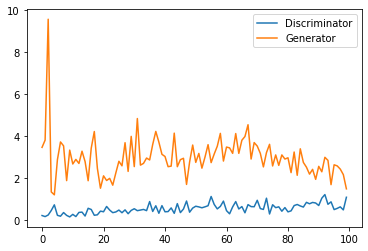

In [ ]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.legend()
plt.show()

Let us now take a look at some generated images.

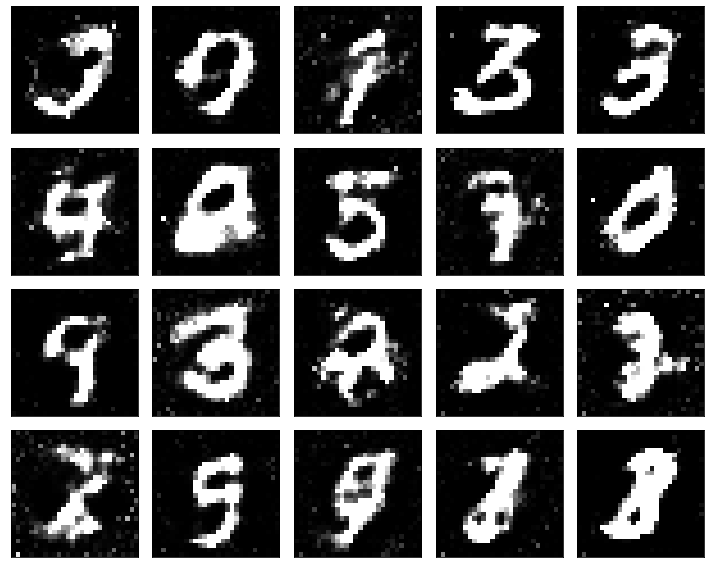

In [ ]:
latent_samples   = make_latent_samples(20, latent_size)
generated_digits = generator.predict(latent_samples)

plt.figure(figsize=(10, 8))
for i in range(20):
  img = deprocess(generated_digits[i])
  plt.subplot(4, 5, i+1)
  plt.imshow(img, cmap='gray')
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show()